In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.metrics import accuracy_score
import pandas as pd
from PIL import Image


In [3]:
# Update with the correct paths for your dataset
dataset_folder = '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data'
train_csv_path = os.path.join(dataset_folder, '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/primary_train.csv')
val_csv_path = os.path.join(dataset_folder, '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/primary_valid.csv')
test_csv_path = os.path.join(dataset_folder, '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/primary_test.csv')
image_folder = os.path.join(dataset_folder, 'images')

In [4]:
# Define a custom dataset class for the dataset with the new structure
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, image_folder, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(self.data.iloc[idx, 1])  # Assuming the label column is at index 1
        return image, label

In [5]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Update model initialization for ResNet-18
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Classifier, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)

# Instantiate the custom ResNet-50 model
model = ResNet18Classifier(num_classes=9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [ ]:
# import torchvision.models as models



# # ... Rest of the code ...

# # Instantiate the ResNet18-based model
# model = ResNet18Classifier(num_classes)  # Update to ResNet18 variant

# # ... Rest of the code ...

# # Update the optimizer to use ResNet-18 parameters
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # ... Rest of the code ...


In [7]:
# Create datasets using the new structure
train_dataset = CustomDatasetFromCSV(train_csv_path, image_folder, transform=transform)
val_dataset = CustomDatasetFromCSV(val_csv_path, image_folder, transform=transform)
test_dataset = CustomDatasetFromCSV(test_csv_path, image_folder, transform=transform)

In [8]:
batch_size=32
# Split the datasets and create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Step 3: Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet18Classifier(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [10]:
# Initialize variables to keep track of the best model
best_validation_loss = float('inf')
best_model_path = '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/ResNet18_model.pth'

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    predictions = []
    true_labels = []

    for images, labels in train_loader:  # Assuming you have defined train_loader
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Loss computation
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # Compute training accuracy and loss
    training_accuracy = accuracy_score(true_labels, predictions)
    training_loss = total_loss / len(train_loader)  # Compute the average loss

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_total_loss = 0.0
    val_predictions = []
    val_true_labels = []

    for images, labels in val_loader:  # Assuming you have defined val_loader
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_predictions.extend(predicted.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    # Compute validation accuracy and loss
    validation_accuracy = accuracy_score(val_true_labels, val_predictions)
    validation_loss = val_total_loss / len(val_loader)  # Compute the average loss

    # Save the model with the best validation loss
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(model.state_dict(), best_model_path)

    # Print the metrics for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'resnet18_model.pth')

# Save the best model based on validation loss
if os.path.exists(best_model_path):
    os.remove(best_model_path)  # Remove previous best model
torch.save(model.state_dict(), best_model_path)
print(f"Best model saved at: {best_model_path}")


Epoch 1/100:
Training Loss: 0.4900, Training Accuracy: 0.8560
Validation Loss: 0.2131, Validation Accuracy: 0.9119
Epoch 2/100:
Training Loss: 0.1933, Training Accuracy: 0.9399
Validation Loss: 0.1115, Validation Accuracy: 0.9559
Epoch 3/100:
Training Loss: 0.1902, Training Accuracy: 0.9399
Validation Loss: 0.3685, Validation Accuracy: 0.8546
Epoch 4/100:
Training Loss: 0.1133, Training Accuracy: 0.9671
Validation Loss: 0.0827, Validation Accuracy: 0.9692
Epoch 5/100:
Training Loss: 0.1255, Training Accuracy: 0.9580
Validation Loss: 0.0654, Validation Accuracy: 0.9648
Epoch 6/100:
Training Loss: 0.0547, Training Accuracy: 0.9790
Validation Loss: 0.0286, Validation Accuracy: 0.9868
Epoch 7/100:
Training Loss: 0.0391, Training Accuracy: 0.9853
Validation Loss: 0.0749, Validation Accuracy: 0.9736
Epoch 8/100:
Training Loss: 0.0322, Training Accuracy: 0.9960
Validation Loss: 0.0139, Validation Accuracy: 0.9956
Epoch 9/100:
Training Loss: 0.0956, Training Accuracy: 0.9728
Validation Loss: 0

In [6]:
import pandas as pd
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# CustomResNet50 model definition and initialization (include the CustomResNet50 class definition here)

# Load the test data
test_csv_file = '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/test/output.csv'
test_data = pd.read_csv(test_csv_file)

# Custom dataset class for test data
class TestDataset(Dataset):
    def __init__(self, data, image_dir, transform=None):
        self.data = data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

# Define transforms for test data (similar to training)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a dataset and data loader for test data
test_image_dir = '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/test/classification_dataset'
test_dataset = TestDataset(test_data, test_image_dir, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Load the trained model (CustomResNet50)
model = ResNet18Classifier(num_classes=9)  # Use the custom model
model.load_state_dict(torch.load('/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/ResNet18_model.pth'))

model.eval()  # Set the model to evaluation mode

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Testing loop
predictions = []

with torch.no_grad():
    for images in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Print the predictions
print("Predictions:", predictions)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predictions: [4, 0, 2, 0, 2, 8, 5, 5, 5, 5, 5, 3, 4, 4, 5, 0, 3, 5, 3, 5, 4, 3, 5, 0, 7, 1, 5, 1, 0, 8, 2, 5, 4, 5, 0, 2, 3, 5, 3, 3, 0, 7, 8, 0, 2, 1, 4, 4, 5, 7, 8, 2, 1, 0, 3, 4, 0, 7, 7, 7, 2, 0, 5, 1, 5, 0, 0, 4, 2, 3, 8, 5, 7, 5, 2, 2, 7, 4, 4, 5, 2, 5, 3, 4, 0, 5, 5, 5, 3, 2, 8, 0, 4, 2, 0, 2, 8, 3, 0, 2, 5, 3, 7, 3, 7, 1, 0, 1, 4, 7, 2, 5, 0, 5, 4, 7, 4, 3, 2, 3, 0, 8, 1, 4, 0, 4, 7, 4, 3, 0, 1, 6, 1, 7, 5, 5, 0, 1, 3, 4, 7, 7, 2, 7, 2, 8, 3, 8, 5, 5, 2, 8, 1, 2, 2, 3, 4, 0, 5, 7, 2, 0, 7, 0, 2, 3, 5, 0, 7, 1, 0, 7, 3, 4, 8, 1, 7, 3, 8, 7, 0, 2, 5, 8, 0, 5, 0, 5, 8, 5]


In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming ground truth labels for the test data are in test_data['label']
# Replace 'test_data['label']' with the actual ground truth labels from your test data

# Calculate accuracy
ground_truth_labels = test_data['label'].tolist()  # Ground truth labels
accuracy = accuracy_score(ground_truth_labels, predictions)

# Calculate class-wise accuracy using a confusion matrix
confusion = confusion_matrix(ground_truth_labels, predictions)
class_accuracy = confusion.diagonal() / confusion.sum(axis=1)

# Print the overall accuracy
print("Overall Accuracy:", accuracy * 100, "%")

# Print class-wise accuracy
for i, acc in enumerate(class_accuracy):
    print(f"Class {i}: {acc * 100:.2f}%")

# Print a detailed classification report
report = classification_report(ground_truth_labels, predictions, target_names=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6", "Class 7", "Class 8"])
print(report)


Overall Accuracy: 52.63157894736842 %
Class 0: 78.57%
Class 1: 28.57%
Class 2: 100.00%
Class 3: 29.41%
Class 4: 70.59%
Class 5: 43.75%
Class 6: 100.00%
Class 7: 60.53%
Class 8: nan%
              precision    recall  f1-score   support

     Class 0       0.35      0.79      0.49        14
     Class 1       0.71      0.29      0.41        35
     Class 2       0.76      1.00      0.86        19
     Class 3       0.43      0.29      0.35        34
     Class 4       0.55      0.71      0.62        17
     Class 5       0.39      0.44      0.41        32
     Class 6       1.00      1.00      1.00         1
     Class 7       1.00      0.61      0.75        38
     Class 8       0.00      0.00      0.00         0

    accuracy                           0.53       190
   macro avg       0.58      0.57      0.54       190
weighted avg       0.63      0.53      0.54       190



<ipython-input-7-64f277a80938>:12: RuntimeWarning: invalid value encountered in divide
  class_accuracy = confusion.diagonal() / confusion.sum(axis=1)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this be

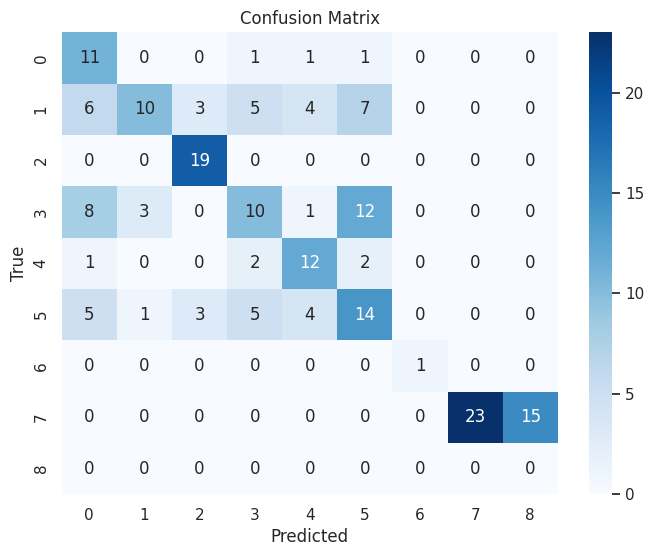

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Ground truth labels for the test data (modify this based on your actual ground truth labels)
# Assuming ground_truth_labels is a list/array of actual labels corresponding to the test data
Predictions = [4, 0, 2, 0, 2, 8, 5, 5, 5, 5, 5, 3, 4, 4, 5, 0, 3, 5, 3, 5, 4, 3, 5, 0, 7, 1, 5, 1, 0, 8, 2, 5, 4, 5, 0, 2, 3, 5, 3, 3, 0, 7, 8, 0, 2, 1, 4, 4, 5, 7, 8, 2, 1, 0, 3, 4, 0, 7, 7, 7, 2, 0, 5, 1, 5, 0, 0, 4, 2, 3, 8, 5, 7, 5, 2, 2, 7, 4, 4, 5, 2, 5, 3, 4, 0, 5, 5, 5, 3, 2, 8, 0, 4, 2, 0, 2, 8, 3, 0, 2, 5, 3, 7, 3, 7, 1, 0, 1, 4, 7, 2, 5, 0, 5, 4, 7, 4, 3, 2, 3, 0, 8, 1, 4, 0, 4, 7, 4, 3, 0, 1, 6, 1, 7, 5, 5, 0, 1, 3, 4, 7, 7, 2, 7, 2, 8, 3, 8, 5, 5, 2, 8, 1, 2, 2, 3, 4, 0, 5, 7, 2, 0, 7, 0, 2, 3, 5, 0, 7, 1, 0, 7, 3, 4, 8, 1, 7, 3, 8, 7, 0, 2, 5, 8, 0, 5, 0, 5, 8, 5]

ground_truth_labels = [4, 1, 2, 3, 2, 7, 1, 1, 1, 5, 1, 3, 4, 5, 3, 0, 4, 5, 1, 3, 4, 3, 1, 4, 7, 5, 1, 1, 1, 7, 2, 5, 5, 5, 5, 2, 5, 5, 3, 1, 0, 7, 7, 3, 2, 3, 4, 3, 5, 7, 7, 2, 1, 3, 1, 0, 3, 7, 7, 7, 2, 0, 3, 3, 4, 1, 5, 4, 2, 3, 7, 5, 7, 3, 2, 2, 7, 4, 4, 3, 2, 5, 3, 1, 5, 0, 5, 3, 1, 2, 7, 0, 5, 2, 0, 2, 7, 5, 0, 1, 3, 1, 7, 5, 7, 1, 1, 1, 4, 7, 2, 3, 3, 4, 4, 7, 4, 0, 2, 3, 1, 7, 1, 4, 0, 5, 7, 1, 3, 5, 1, 6, 1, 7, 5, 5, 5, 1, 3, 1, 7, 7, 2, 7, 5, 7, 3, 7, 3, 5, 5, 7, 1, 1, 1, 5, 1, 3, 3, 7, 5, 0, 7, 0, 2, 5, 1, 0, 7, 3, 3, 7, 3, 4, 7, 1, 7, 4, 7, 7, 3, 2, 3, 7, 0, 5, 1, 3, 7, 5]
# Calculate the confusion matrix
cm = confusion_matrix(ground_truth_labels, predictions)

# Get class labels
class_labels = unique_labels(ground_truth_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
